<a href="https://colab.research.google.com/github/Andysimps0n/DL_lecture/blob/main/CNN_with_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns
import matplotlib.pyplot as plt


In [12]:
#데이터 갖고와서 처리도 좀 하기
transform = transforms.Compose([
    transforms.Pad(2),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

In [13]:
from torch.utils.data import DataLoader, TensorDataset


def prepare_gpu_loader(dataset, batch_size, shuffle=False):
  x = torch.stack([data for data, _ in dataset]).to('cuda')
  y = torch.tensor([target for _, target in dataset]).to('cuda')

  gpu_dataset = TensorDataset(x, y)
  return DataLoader(gpu_dataset, batch_size=batch_size, shuffle=shuffle)


batch_size = 128
train_loader = prepare_gpu_loader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = prepare_gpu_loader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = prepare_gpu_loader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.c1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.p1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.c2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.p2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 60)
    self.fc3 = nn.Linear(60, 10)

  def forward(self, x):
    x = self.p1(F.relu(self.c1(x)))
    x = self.p2(F.relu(self.c2(x)))

    x = torch.flatten(x,1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

In [25]:
model = CNN()
model.to('cuda')
loss_function = nn.CrossEntropyLoss()

lr = 0.005
optimizer = optim.Adam(model.parameters(), lr=lr)

list_train_loss = []
list_val_loss = []
list_acc = []

epoch = 20 # CNN은 성능이 좋아 20회 정도로도 충분합니다.

for i in range(epoch):
    model.train()
    train_loss = 0
    for input_X, true_y in train_loader:

        optimizer.zero_grad()
        pred_y = model(input_X)
        loss = loss_function(pred_y, true_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    list_train_loss.append(avg_train_loss)

    # --- [VALIDATION PHASE] ---
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for input_X, true_y in val_loader:
            pred_y = model(input_X)
            val_loss += loss_function(pred_y, true_y).item()

            prediction = pred_y.max(1)[1]
            correct += (prediction == true_y).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    acc = (correct / len(val_loader.dataset)) * 100

    list_val_loss.append(avg_val_loss)
    list_acc.append(acc)

    print(f"Epoch [{i+1}/{epoch}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: {acc:.2f}%")

Epoch [1/20] | Train Loss: 0.2076 | Val Loss: 0.0611 | Acc: 98.03%
Epoch [2/20] | Train Loss: 0.0617 | Val Loss: 0.0571 | Acc: 98.19%
Epoch [3/20] | Train Loss: 0.0480 | Val Loss: 0.0501 | Acc: 98.54%
Epoch [4/20] | Train Loss: 0.0383 | Val Loss: 0.0549 | Acc: 98.35%
Epoch [5/20] | Train Loss: 0.0365 | Val Loss: 0.0485 | Acc: 98.57%
Epoch [6/20] | Train Loss: 0.0282 | Val Loss: 0.0559 | Acc: 98.53%
Epoch [7/20] | Train Loss: 0.0312 | Val Loss: 0.0477 | Acc: 98.82%
Epoch [8/20] | Train Loss: 0.0284 | Val Loss: 0.0449 | Acc: 98.81%
Epoch [9/20] | Train Loss: 0.0232 | Val Loss: 0.0490 | Acc: 98.78%
Epoch [10/20] | Train Loss: 0.0262 | Val Loss: 0.0391 | Acc: 98.87%
Epoch [11/20] | Train Loss: 0.0228 | Val Loss: 0.0538 | Acc: 98.67%
Epoch [12/20] | Train Loss: 0.0258 | Val Loss: 0.0614 | Acc: 98.57%
Epoch [13/20] | Train Loss: 0.0216 | Val Loss: 0.0437 | Acc: 98.92%
Epoch [14/20] | Train Loss: 0.0217 | Val Loss: 0.0654 | Acc: 98.64%
Epoch [15/20] | Train Loss: 0.0224 | Val Loss: 0.0448 | A

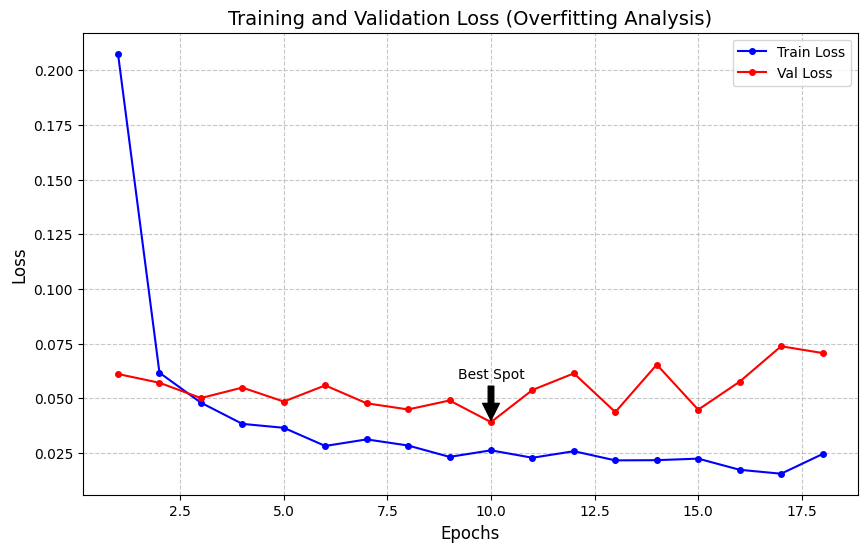

In [28]:
import matplotlib.pyplot as plt

epochs = list(range(1, 19))
train_losses = [0.2076, 0.0617, 0.0480, 0.0383, 0.0365, 0.0282, 0.0312, 0.0284, 0.0232,
                0.0262, 0.0228, 0.0258, 0.0216, 0.0217, 0.0224, 0.0173, 0.0155, 0.0245]
val_losses = [0.0611, 0.0571, 0.0501, 0.0549, 0.0485, 0.0559, 0.0477, 0.0449, 0.0490,
              0.0391, 0.0538, 0.0614, 0.0437, 0.0654, 0.0448, 0.0576, 0.0738, 0.0707]

plt.figure(figsize=(10, 6))

# 그래프 그리기
plt.plot(epochs, train_losses, 'b-o', label='Train Loss', markersize=4)
plt.plot(epochs, val_losses, 'r-o', label='Val Loss', markersize=4)

# 최적의 지점(Overfitting 시작 직전) 표시
min_val_loss_idx = val_losses.index(min(val_losses))
plt.annotate('Best Spot', xy=(epochs[min_val_loss_idx], val_losses[min_val_loss_idx]),
             xytext=(epochs[min_val_loss_idx], val_losses[min_val_loss_idx] + 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center')

# 그래프 설정
plt.title('Training and Validation Loss (Overfitting Analysis)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.show()